<a href="https://colab.research.google.com/github/RicardoMourao-py/CNN-ALZHEIMER-CLASSIFICATION/blob/main/main_kaggle_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import auth
# from google.cloud import storage
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# !unzip data_slices/VeryMildDemented.zip
!unzip dataset_binario.zip
# !rm -r dataset_binario

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: dataset_binario/Demented/moderateDem5.jpg  
  inflating: dataset_binario/Demented/moderateDem50.jpg  
  inflating: dataset_binario/Demented/moderateDem51.jpg  
  inflating: dataset_binario/Demented/moderateDem6.jpg  
  inflating: dataset_binario/Demented/moderateDem7.jpg  
  inflating: dataset_binario/Demented/moderateDem8.jpg  
  inflating: dataset_binario/Demented/moderateDem9.jpg  
  inflating: dataset_binario/Demented/verymildDem0.jpg  
  inflating: dataset_binario/Demented/verymildDem1.jpg  
  inflating: dataset_binario/Demented/verymildDem10.jpg  
  inflating: dataset_binario/Demented/verymildDem100.jpg  
  inflating: dataset_binario/Demented/verymildDem1000.jpg  
  inflating: dataset_binario/Demented/verymildDem1001.jpg  
  inflating: dataset_binario/Demented/verymildDem1002.jpg  
  inflating: dataset_binario/Demented/verymildDem1003.jpg  
  inflating: dataset_binario/Demented/verymildDem1004.jpg  
  inflati

In [ ]:
folder = './dataset_binario/'
folder_path = pathlib.Path(folder)

## Visualizando Imagem

<PIL.Image.Image image mode=RGB size=176x208 at 0x7E29B04DC3A0>


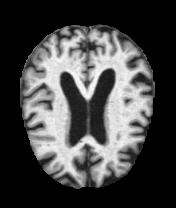

In [ ]:
photo = load_img('./dataset_binario/Demented/26 (19).jpg')
print(photo)
photo

## Imagens e suas Classificações

In [ ]:
for file in listdir(folder):
    print(file)

NonDemented
Demented


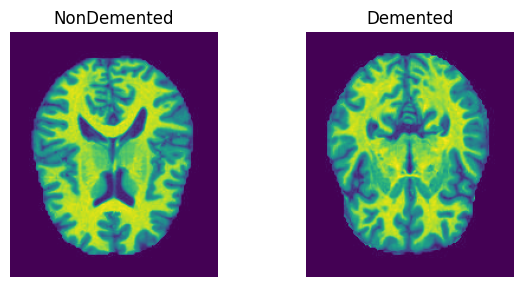

In [ ]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder+'/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [ ]:
# counting the number of images in each category
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

NonDemented 3200
Demented 3200


## Image Generator

In [ ]:
# Criando o gerador de dados de imagem para ter mais amostras

IMG_SIZE = 128                  # tamanho da imagem de saída após o pré-processamento e aumento de dados
DIM = (IMG_SIZE, IMG_SIZE)      # tupla que especifica as dimensões da imagem de saída

ZOOM = [.99, 1.01]              # zoom que será aplicada às imagens
BRIGHT_RANGE = [0.8, 1.2]       #  ajuste de brilho
HORZ_FLIP = True                # espelhamento horizontal
FILL_MODE = "constant"          # pixels adicionados durante o redimensionamento serão preenchidos com um valor constante
DATA_FORMAT = "channels_last"   # formato dos dados é (altura, largura, canais)

In [ ]:
# Gerador de dados de treinamento com aumento de dados e suas normalizações
train_generator = ImageDataGenerator(
                                      rescale = 1./255,
                                      brightness_range=BRIGHT_RANGE,
                                      zoom_range=ZOOM,
                                      data_format=DATA_FORMAT,
                                      fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP
                                    )

train_data_gen = train_generator.flow_from_directory(
                                                      directory=folder,
                                                      target_size=DIM,
                                                      batch_size=6500,
                                                      shuffle=False
                                                    )

Found 6400 images belonging to 2 classes.


In [ ]:
CLASSES = list(train_data_gen.class_indices.keys())
CLASSES
# def show_images(generator,y_pred=None):
#     # get image lables
#     labels =dict(zip([0,1,2,3], CLASSES))

#     # get a batch of images
#     x,y = generator.next()

#     # display a grid of 9 images
#     plt.figure(figsize=(7, 7))
#     if y_pred is None:
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             idx = randint(0, 6400)
#             plt.imshow(x[idx])
#             plt.axis("off")
#             plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
#     else:
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(x[i])
#             plt.axis("off")
#             plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# # Display Train Images
# show_images(train_data_gen)

['Demented', 'NonDemented']

In [ ]:
# retorna o próximo lote de dados e suas respectivas etiquetas.
train_data, train_labels = train_data_gen.next()

In [ ]:
train_data.shape, train_labels.shape

((6400, 128, 128, 3), (6400, 2))

In [ ]:
# train_labels = np.argmax(train_labels, axis=1)
# train_labels

array([1, 1, 1, ..., 2, 2, 2])

In [ ]:
# O SMOTE é uma técnica comumente usada para lidar com conjuntos de dados de classificação que
# têm classes minoritárias com menos exemplos do que as classes majoritárias.
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

# Reformando os dados de volta para o formato original
# train_data = train_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
# train_labels = np.eye(train_labels.shape[1])[train_labels]

print(train_data.shape, train_labels.shape)

(6400, 49152) (6400, 1)


In [ ]:
# alterar as dimensões de um array sem alterar os dados em si
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400,)


In [ ]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())

    return block

In [ ]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [ ]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [ ]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(2, activation='softmax')
    ], name = "cnn_model")

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=2)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_31 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 sequential_21 (Sequential)  (None, 32, 32, 32)        14016     
                                                                 
 sequential_22 (Sequential)  (None, 16, 16, 64)        55680     
                                                                 
 sequential_23 (Sequential)  (None, 8, 8, 128)         221952    
                                                         

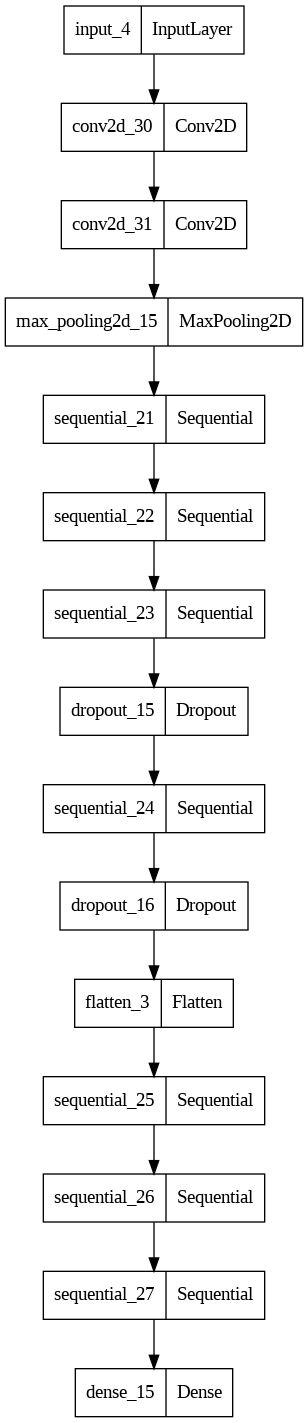

In [ ]:
plot_model(model)

In [ ]:
CALLBACKS = [
    EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]

In [ ]:
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,callbacks=CALLBACKS)

Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 0.9702 - acc: 0.5049 - auc: 0.5023 - f1_score: 0.5049

128/128 [==============================] - 23s 48ms/step - loss: 0.9702 - acc: 0.5049 - auc: 0.5023 - f1_score: 0.5049 - val_loss: 0.8288 - val_acc: 0.5000 - val_auc: 0.5286 - val_f1_score: 0.3333
Epoch 2/50
127/128 [============================>.] - ETA: 0s - loss: 0.7998 - acc: 0.5278 - auc: 0.5375 - f1_score: 0.5278

128/128 [==============================] - 5s 39ms/step - loss: 0.8006 - acc: 0.5264 - auc: 0.5361 - f1_score: 0.5264 - val_loss: 0.7098 - val_acc: 0.5000 - val_auc: 0.5419 - val_f1_score: 0.3333
Epoch 3/50
127/128 [============================>.] - ETA: 0s - loss: 0.6890 - acc: 0.6053 - auc: 0.6474 - f1_score: 0.6048

128/128 [==============================] - 5s 41ms/step - loss: 0.6885 - acc: 0.6057 - auc: 0.6479 - f1_score: 0.6053 - val_loss: 1.4298 - val_acc: 0.5000 - val_auc: 0.5114 - val_f1_score: 0.3333
Epoch 4/50
127/128 [============================>.] - ETA: 0s - loss: 0.6456 - acc: 0.6449 - auc: 0.6960 - f1_score: 0.6445

128/128 [==============================] - 5s 40ms/step - loss: 0.6448 - acc: 0.6460 - auc: 0.6970 - f1_score: 0.6455 - val_loss: 0.6342 - val_acc: 0.6504 - val_auc: 0.7032 - val_f1_score: 0.6500
Epoch 5/50
127/128 [============================>.] - ETA: 0s - loss: 0.6297 - acc: 0.6649 - auc: 0.7110 - f1_score: 0.6640

128/128 [==============================] - 5s 41ms/step - loss: 0.6289 - acc: 0.6658 - auc: 0.7118 - f1_score: 0.6649 - val_loss: 3.0667 - val_acc: 0.5020 - val_auc: 0.5510 - val_f1_score: 0.3377
Epoch 6/50
127/128 [============================>.] - ETA: 0s - loss: 0.6204 - acc: 0.6752 - auc: 0.7206 - f1_score: 0.6734

128/128 [==============================] - 5s 39ms/step - loss: 0.6207 - acc: 0.6750 - auc: 0.7204 - f1_score: 0.6733 - val_loss: 2.9805 - val_acc: 0.5010 - val_auc: 0.5502 - val_f1_score: 0.3355
Epoch 7/50
127/128 [============================>.] - ETA: 0s - loss: 0.5951 - acc: 0.6907 - auc: 0.7489 - f1_score: 0.6897

128/128 [==============================] - 5s 39ms/step - loss: 0.5963 - acc: 0.6899 - auc: 0.7477 - f1_score: 0.6890 - val_loss: 1.4591 - val_acc: 0.5000 - val_auc: 0.5542 - val_f1_score: 0.3333
Epoch 8/50
127/128 [============================>.] - ETA: 0s - loss: 0.5890 - acc: 0.6976 - auc: 0.7564 - f1_score: 0.6963

128/128 [==============================] - 5s 41ms/step - loss: 0.5890 - acc: 0.6975 - auc: 0.7565 - f1_score: 0.6962 - val_loss: 0.9854 - val_acc: 0.5000 - val_auc: 0.6109 - val_f1_score: 0.3333
Epoch 9/50
127/128 [============================>.] - ETA: 0s - loss: 0.5847 - acc: 0.7018 - auc: 0.7615 - f1_score: 0.7009

128/128 [==============================] - 5s 39ms/step - loss: 0.5846 - acc: 0.7021 - auc: 0.7617 - f1_score: 0.7013 - val_loss: 1.6083 - val_acc: 0.5000 - val_auc: 0.5456 - val_f1_score: 0.3333
Epoch 10/50
127/128 [============================>.] - ETA: 0s - loss: 0.5802 - acc: 0.7096 - auc: 0.7655 - f1_score: 0.7084

128/128 [==============================] - 5s 43ms/step - loss: 0.5794 - acc: 0.7097 - auc: 0.7663 - f1_score: 0.7085 - val_loss: 1.3231 - val_acc: 0.5000 - val_auc: 0.6139 - val_f1_score: 0.3333
Epoch 11/50
127/128 [============================>.] - ETA: 0s - loss: 0.5774 - acc: 0.7089 - auc: 0.7669 - f1_score: 0.7072

128/128 [==============================] - 5s 39ms/step - loss: 0.5778 - acc: 0.7090 - auc: 0.7668 - f1_score: 0.7073 - val_loss: 0.9627 - val_acc: 0.5371 - val_auc: 0.6308 - val_f1_score: 0.4311
Epoch 12/50
127/128 [============================>.] - ETA: 0s - loss: 0.5679 - acc: 0.7254 - auc: 0.7784 - f1_score: 0.7248

128/128 [==============================] - 5s 39ms/step - loss: 0.5676 - acc: 0.7251 - auc: 0.7787 - f1_score: 0.7245 - val_loss: 1.7791 - val_acc: 0.5000 - val_auc: 0.6158 - val_f1_score: 0.3333
Epoch 13/50
127/128 [============================>.] - ETA: 0s - loss: 0.5609 - acc: 0.7190 - auc: 0.7835 - f1_score: 0.7182

128/128 [==============================] - 5s 40ms/step - loss: 0.5601 - acc: 0.7195 - auc: 0.7843 - f1_score: 0.7187 - val_loss: 0.8088 - val_acc: 0.5049 - val_auc: 0.6301 - val_f1_score: 0.3441
Epoch 14/50
127/128 [============================>.] - ETA: 0s - loss: 0.5550 - acc: 0.7212 - auc: 0.7901 - f1_score: 0.7197

128/128 [==============================] - 5s 39ms/step - loss: 0.5537 - acc: 0.7224 - auc: 0.7915 - f1_score: 0.7209 - val_loss: 0.5890 - val_acc: 0.6875 - val_auc: 0.7520 - val_f1_score: 0.6817
Epoch 15/50
127/128 [============================>.] - ETA: 0s - loss: 0.5470 - acc: 0.7281 - auc: 0.7970 - f1_score: 0.7275

128/128 [==============================] - 6s 43ms/step - loss: 0.5474 - acc: 0.7280 - auc: 0.7966 - f1_score: 0.7275 - val_loss: 1.3728 - val_acc: 0.5010 - val_auc: 0.6358 - val_f1_score: 0.3355
Epoch 16/50
127/128 [============================>.] - ETA: 0s - loss: 0.5427 - acc: 0.7242 - auc: 0.7995 - f1_score: 0.7232

128/128 [==============================] - 5s 39ms/step - loss: 0.5419 - acc: 0.7256 - auc: 0.8004 - f1_score: 0.7246 - val_loss: 3.1083 - val_acc: 0.5000 - val_auc: 0.5254 - val_f1_score: 0.3333
Epoch 17/50
127/128 [============================>.] - ETA: 0s - loss: 0.5384 - acc: 0.7350 - auc: 0.8071 - f1_score: 0.7347

128/128 [==============================] - 6s 44ms/step - loss: 0.5388 - acc: 0.7341 - auc: 0.8065 - f1_score: 0.7338 - val_loss: 2.7074 - val_acc: 0.5039 - val_auc: 0.5785 - val_f1_score: 0.3420
Epoch 18/50
127/128 [============================>.] - ETA: 0s - loss: 0.5115 - acc: 0.7458 - auc: 0.8256 - f1_score: 0.7455

128/128 [==============================] - 5s 40ms/step - loss: 0.5118 - acc: 0.7458 - auc: 0.8254 - f1_score: 0.7455 - val_loss: 1.2698 - val_acc: 0.5010 - val_auc: 0.6360 - val_f1_score: 0.3355
Epoch 19/50
127/128 [============================>.] - ETA: 0s - loss: 0.5195 - acc: 0.7456 - auc: 0.8227 - f1_score: 0.7454

128/128 [==============================] - 5s 39ms/step - loss: 0.5191 - acc: 0.7458 - auc: 0.8230 - f1_score: 0.7457 - val_loss: 0.9626 - val_acc: 0.6094 - val_auc: 0.6728 - val_f1_score: 0.5447
Epoch 20/50
127/128 [============================>.] - ETA: 0s - loss: 0.5119 - acc: 0.7530 - auc: 0.8276 - f1_score: 0.7526

128/128 [==============================] - 5s 41ms/step - loss: 0.5118 - acc: 0.7532 - auc: 0.8277 - f1_score: 0.7528 - val_loss: 0.8145 - val_acc: 0.5195 - val_auc: 0.6448 - val_f1_score: 0.3768
Epoch 21/50
127/128 [============================>.] - ETA: 0s - loss: 0.5113 - acc: 0.7463 - auc: 0.8280 - f1_score: 0.7462

128/128 [==============================] - 5s 39ms/step - loss: 0.5120 - acc: 0.7456 - auc: 0.8274 - f1_score: 0.7455 - val_loss: 0.7201 - val_acc: 0.6729 - val_auc: 0.7300 - val_f1_score: 0.6432
Epoch 22/50
127/128 [============================>.] - ETA: 0s - loss: 0.5168 - acc: 0.7456 - auc: 0.8226 - f1_score: 0.7455

128/128 [==============================] - 5s 39ms/step - loss: 0.5168 - acc: 0.7454 - auc: 0.8225 - f1_score: 0.7453 - val_loss: 2.2989 - val_acc: 0.5000 - val_auc: 0.5767 - val_f1_score: 0.3333
Epoch 23/50
127/128 [============================>.] - ETA: 0s - loss: 0.4964 - acc: 0.7616 - auc: 0.8392 - f1_score: 0.7615

128/128 [==============================] - 5s 41ms/step - loss: 0.4963 - acc: 0.7617 - auc: 0.8394 - f1_score: 0.7617 - val_loss: 0.5780 - val_acc: 0.7051 - val_auc: 0.7938 - val_f1_score: 0.7033
Epoch 24/50
127/128 [============================>.] - ETA: 0s - loss: 0.4742 - acc: 0.7746 - auc: 0.8545 - f1_score: 0.7746

128/128 [==============================] - 5s 39ms/step - loss: 0.4779 - acc: 0.7725 - auc: 0.8520 - f1_score: 0.7724 - val_loss: 1.0435 - val_acc: 0.5566 - val_auc: 0.6613 - val_f1_score: 0.4517
Epoch 25/50
127/128 [============================>.] - ETA: 0s - loss: 0.4295 - acc: 0.8004 - auc: 0.8829 - f1_score: 0.8004

128/128 [==============================] - 5s 43ms/step - loss: 0.4303 - acc: 0.7996 - auc: 0.8824 - f1_score: 0.7996 - val_loss: 0.4726 - val_acc: 0.7676 - val_auc: 0.8543 - val_f1_score: 0.7673
Epoch 26/50
127/128 [============================>.] - ETA: 0s - loss: 0.4058 - acc: 0.8157 - auc: 0.8970 - f1_score: 0.8157

128/128 [==============================] - 5s 39ms/step - loss: 0.4054 - acc: 0.8159 - auc: 0.8972 - f1_score: 0.8159 - val_loss: 0.8427 - val_acc: 0.6260 - val_auc: 0.6784 - val_f1_score: 0.5978
Epoch 27/50
127/128 [============================>.] - ETA: 0s - loss: 0.3934 - acc: 0.8206 - auc: 0.9036 - f1_score: 0.8206

128/128 [==============================] - 5s 39ms/step - loss: 0.3933 - acc: 0.8208 - auc: 0.9036 - f1_score: 0.8208 - val_loss: 0.6003 - val_acc: 0.6943 - val_auc: 0.7645 - val_f1_score: 0.6738
Epoch 28/50
127/128 [============================>.] - ETA: 0s - loss: 0.3459 - acc: 0.8492 - auc: 0.9262 - f1_score: 0.8491

128/128 [==============================] - 5s 40ms/step - loss: 0.3465 - acc: 0.8489 - auc: 0.9259 - f1_score: 0.8488 - val_loss: 0.5676 - val_acc: 0.7256 - val_auc: 0.8020 - val_f1_score: 0.7195
Epoch 29/50
127/128 [============================>.] - ETA: 0s - loss: 0.3146 - acc: 0.8659 - auc: 0.9392 - f1_score: 0.8658

128/128 [==============================] - 5s 39ms/step - loss: 0.3150 - acc: 0.8660 - auc: 0.9390 - f1_score: 0.8659 - val_loss: 0.8447 - val_acc: 0.6816 - val_auc: 0.7556 - val_f1_score: 0.6539
Epoch 30/50
127/128 [============================>.] - ETA: 0s - loss: 0.2789 - acc: 0.8819 - auc: 0.9527 - f1_score: 0.8819

128/128 [==============================] - 5s 40ms/step - loss: 0.2790 - acc: 0.8818 - auc: 0.9526 - f1_score: 0.8818 - val_loss: 2.7792 - val_acc: 0.5010 - val_auc: 0.5895 - val_f1_score: 0.3355
Epoch 31/50
127/128 [============================>.] - ETA: 0s - loss: 0.2509 - acc: 0.8971 - auc: 0.9615 - f1_score: 0.8971

128/128 [==============================] - 5s 39ms/step - loss: 0.2520 - acc: 0.8965 - auc: 0.9612 - f1_score: 0.8965 - val_loss: 0.9093 - val_acc: 0.6826 - val_auc: 0.7843 - val_f1_score: 0.6517
Epoch 32/50
127/128 [============================>.] - ETA: 0s - loss: 0.2128 - acc: 0.9102 - auc: 0.9726 - f1_score: 0.9102

128/128 [==============================] - 5s 38ms/step - loss: 0.2126 - acc: 0.9106 - auc: 0.9726 - f1_score: 0.9106 - val_loss: 0.6019 - val_acc: 0.7734 - val_auc: 0.8674 - val_f1_score: 0.7678
Epoch 33/50
128/128 [==============================] - ETA: 0s - loss: 0.1938 - acc: 0.9185 - auc: 0.9770 - f1_score: 0.9184

128/128 [==============================] - 6s 46ms/step - loss: 0.1938 - acc: 0.9185 - auc: 0.9770 - f1_score: 0.9184 - val_loss: 0.9294 - val_acc: 0.6855 - val_auc: 0.7972 - val_f1_score: 0.6569
Epoch 34/50
127/128 [============================>.] - ETA: 0s - loss: 0.1541 - acc: 0.9400 - auc: 0.9854 - f1_score: 0.9399

128/128 [==============================] - 5s 39ms/step - loss: 0.1533 - acc: 0.9404 - auc: 0.9856 - f1_score: 0.9404 - val_loss: 0.5296 - val_acc: 0.8232 - val_auc: 0.8947 - val_f1_score: 0.8230
Epoch 35/50
127/128 [============================>.] - ETA: 0s - loss: 0.2108 - acc: 0.9181 - auc: 0.9730 - f1_score: 0.9180

128/128 [==============================] - 5s 41ms/step - loss: 0.2110 - acc: 0.9180 - auc: 0.9729 - f1_score: 0.9180 - val_loss: 1.1259 - val_acc: 0.5664 - val_auc: 0.6960 - val_f1_score: 0.4704
Epoch 36/50
127/128 [============================>.] - ETA: 0s - loss: 0.1537 - acc: 0.9422 - auc: 0.9854 - f1_score: 0.9422

128/128 [==============================] - 5s 39ms/step - loss: 0.1528 - acc: 0.9426 - auc: 0.9856 - f1_score: 0.9426 - val_loss: 0.5897 - val_acc: 0.7881 - val_auc: 0.8718 - val_f1_score: 0.7834
Epoch 37/50
127/128 [============================>.] - ETA: 0s - loss: 0.1170 - acc: 0.9564 - auc: 0.9911 - f1_score: 0.9564

128/128 [==============================] - 5s 38ms/step - loss: 0.1167 - acc: 0.9565 - auc: 0.9911 - f1_score: 0.9565 - val_loss: 1.3307 - val_acc: 0.6592 - val_auc: 0.7582 - val_f1_score: 0.6172
Epoch 38/50
127/128 [============================>.] - ETA: 0s - loss: 0.1018 - acc: 0.9616 - auc: 0.9933 - f1_score: 0.9616

128/128 [==============================] - 5s 40ms/step - loss: 0.1017 - acc: 0.9617 - auc: 0.9933 - f1_score: 0.9617 - val_loss: 5.5349 - val_acc: 0.5000 - val_auc: 0.5005 - val_f1_score: 0.3333
Epoch 39/50
127/128 [============================>.] - ETA: 0s - loss: 0.1089 - acc: 0.9594 - auc: 0.9926 - f1_score: 0.9594

128/128 [==============================] - 5s 39ms/step - loss: 0.1096 - acc: 0.9590 - auc: 0.9926 - f1_score: 0.9590 - val_loss: 1.2700 - val_acc: 0.6426 - val_auc: 0.7554 - val_f1_score: 0.5947
Epoch 40/50
127/128 [============================>.] - ETA: 0s - loss: 0.0974 - acc: 0.9621 - auc: 0.9943 - f1_score: 0.9621

128/128 [==============================] - 5s 40ms/step - loss: 0.0985 - acc: 0.9619 - auc: 0.9941 - f1_score: 0.9619 - val_loss: 0.5832 - val_acc: 0.8105 - val_auc: 0.8965 - val_f1_score: 0.8070
Epoch 41/50
127/128 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9737 - auc: 0.9967 - f1_score: 0.9737

128/128 [==============================] - 5s 39ms/step - loss: 0.0737 - acc: 0.9734 - auc: 0.9964 - f1_score: 0.9734 - val_loss: 0.9255 - val_acc: 0.7412 - val_auc: 0.8307 - val_f1_score: 0.7271
Epoch 42/50
127/128 [============================>.] - ETA: 0s - loss: 0.1187 - acc: 0.9569 - auc: 0.9912 - f1_score: 0.9569

128/128 [==============================] - 5s 38ms/step - loss: 0.1184 - acc: 0.9570 - auc: 0.9912 - f1_score: 0.9570 - val_loss: 1.3835 - val_acc: 0.6201 - val_auc: 0.7256 - val_f1_score: 0.5591
Epoch 43/50
127/128 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9660 - auc: 0.9947 - f1_score: 0.9660

128/128 [==============================] - 5s 39ms/step - loss: 0.0886 - acc: 0.9663 - auc: 0.9947 - f1_score: 0.9663 - val_loss: 1.3594 - val_acc: 0.6738 - val_auc: 0.7540 - val_f1_score: 0.6395
Epoch 44/50
127/128 [============================>.] - ETA: 0s - loss: 0.0766 - acc: 0.9722 - auc: 0.9961 - f1_score: 0.9722

128/128 [==============================] - 5s 38ms/step - loss: 0.0768 - acc: 0.9722 - auc: 0.9961 - f1_score: 0.9722 - val_loss: 0.4845 - val_acc: 0.8604 - val_auc: 0.9157 - val_f1_score: 0.8603
Epoch 45/50
127/128 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9759 - auc: 0.9968 - f1_score: 0.9759

128/128 [==============================] - 5s 39ms/step - loss: 0.0671 - acc: 0.9756 - auc: 0.9964 - f1_score: 0.9756 - val_loss: 0.5511 - val_acc: 0.8252 - val_auc: 0.9014 - val_f1_score: 0.8248
Epoch 46/50
127/128 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9749 - auc: 0.9964 - f1_score: 0.9749

128/128 [==============================] - 5s 40ms/step - loss: 0.0689 - acc: 0.9751 - auc: 0.9965 - f1_score: 0.9751 - val_loss: 0.6503 - val_acc: 0.8262 - val_auc: 0.8959 - val_f1_score: 0.8252
Epoch 47/50
127/128 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9737 - auc: 0.9958 - f1_score: 0.9737

128/128 [==============================] - 5s 39ms/step - loss: 0.0764 - acc: 0.9727 - auc: 0.9954 - f1_score: 0.9727 - val_loss: 1.4489 - val_acc: 0.6621 - val_auc: 0.7573 - val_f1_score: 0.6219
Epoch 48/50
127/128 [============================>.] - ETA: 0s - loss: 0.0669 - acc: 0.9742 - auc: 0.9972 - f1_score: 0.9742

128/128 [==============================] - 5s 42ms/step - loss: 0.0678 - acc: 0.9736 - auc: 0.9971 - f1_score: 0.9736 - val_loss: 0.5440 - val_acc: 0.8662 - val_auc: 0.9177 - val_f1_score: 0.8662
Epoch 49/50
127/128 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9798 - auc: 0.9977 - f1_score: 0.9798

128/128 [==============================] - 5s 39ms/step - loss: 0.0588 - acc: 0.9800 - auc: 0.9977 - f1_score: 0.9800 - val_loss: 0.9375 - val_acc: 0.7598 - val_auc: 0.8391 - val_f1_score: 0.7504
Epoch 50/50
127/128 [============================>.] - ETA: 0s - loss: 0.0961 - acc: 0.9646 - auc: 0.9937 - f1_score: 0.9646

128/128 [==============================] - 5s 38ms/step - loss: 0.0975 - acc: 0.9641 - auc: 0.9936 - f1_score: 0.9641 - val_loss: 0.4475 - val_acc: 0.8633 - val_auc: 0.9262 - val_f1_score: 0.8633


In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 0s 11ms/step - loss: 0.3193 - acc: 0.8930 - auc: 0.9528 - f1_score: 0.8928
Testing Accuracy: 89.30%


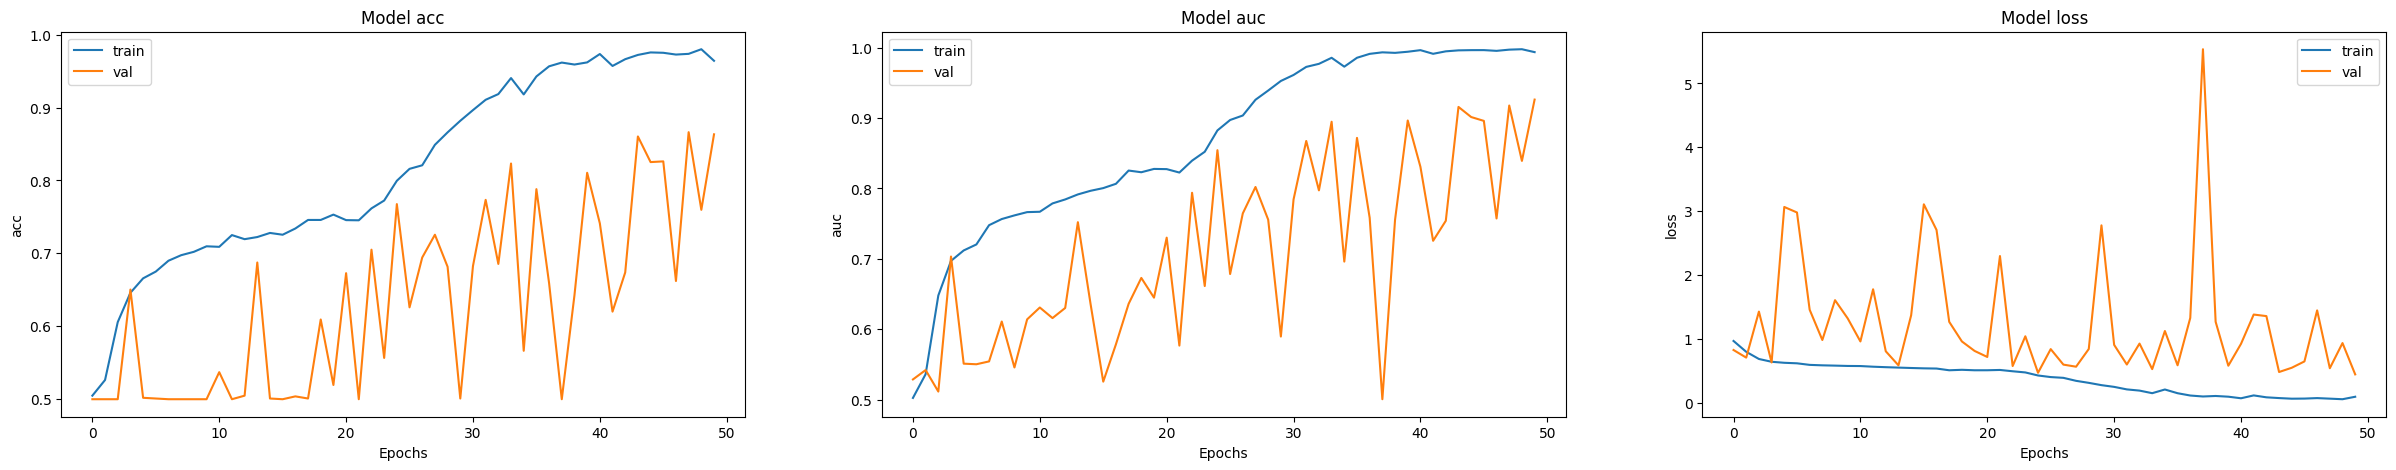

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

40/40 [==============================] - 1s 10ms/step


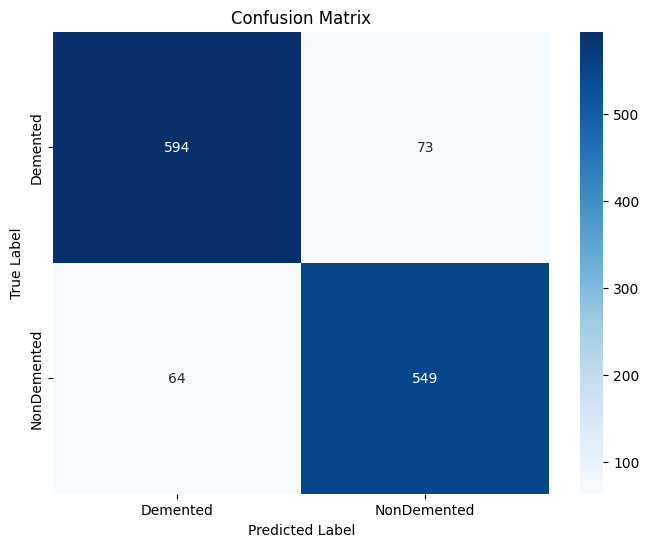

In [ ]:
# Convertendo as previsões para classes
test_predictions = model.predict(test_data)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(test_true_classes, test_predictions_classes)

# Plotando a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculando métricas
accuracy = accuracy_score(test_true_classes, test_predictions_classes)
precision = precision_score(test_true_classes, test_predictions_classes, average='weighted')
recall = recall_score(test_true_classes, test_predictions_classes, average='weighted')
f1 = f1_score(test_true_classes, test_predictions_classes, average='weighted')

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Sensibilidade:", recall)
print("F1-Score:", f1)

Acurácia: 0.89296875
Precisão: 0.893110070435354
Sensibilidade: 0.89296875
F1-Score: 0.8929952400504163


In [ ]:
inception = InceptionV3(input_shape=(128,128,3),include_top=False,weights ='imagenet')

87910968/87910968 [==============================] - 2s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(2, activation='softmax')
    ], name = "inception_cnn_model")
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 dropout_25 (Dropout)        (None, 2, 2, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_127 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense_21 (Dense)            (None, 512)       

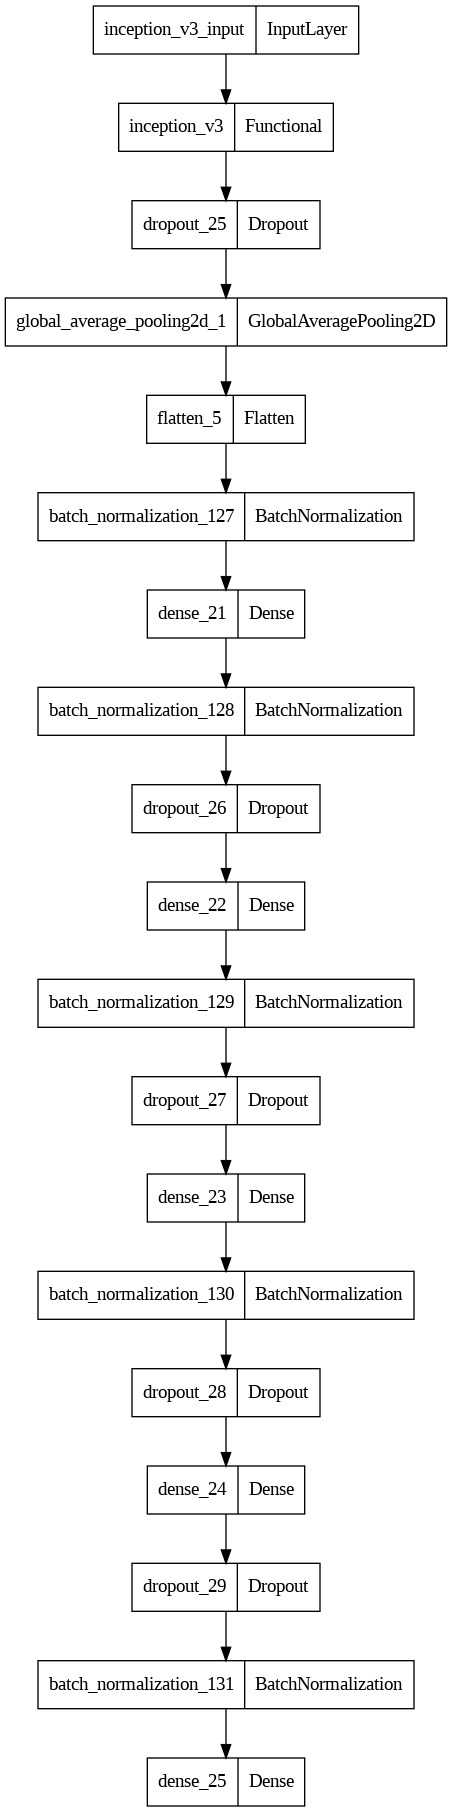

In [ ]:
plot_model(inception_model)

In [ ]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=3)
]

In [ ]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50,callbacks= INCEPT_CALLBACKS)

Epoch 1/50
128/128 [==============================] - 17s 70ms/step - loss: 0.9059 - acc: 0.6403 - auc: 0.7106 - f1_score: 0.6403 - val_loss: 0.6469 - val_acc: 0.6299 - val_auc: 0.7002 - val_f1_score: 0.6200
Epoch 2/50
128/128 [==============================] - 6s 45ms/step - loss: 0.7321 - acc: 0.6079 - auc: 0.6480 - f1_score: 0.6078 - val_loss: 0.5846 - val_acc: 0.6846 - val_auc: 0.7592 - val_f1_score: 0.6834
Epoch 3/50
128/128 [==============================] - 5s 40ms/step - loss: 0.6530 - acc: 0.6455 - auc: 0.6980 - f1_score: 0.6455 - val_loss: 0.5805 - val_acc: 0.6982 - val_auc: 0.7686 - val_f1_score: 0.6981
Epoch 4/50
128/128 [==============================] - 5s 43ms/step - loss: 0.6082 - acc: 0.6831 - auc: 0.7425 - f1_score: 0.6831 - val_loss: 0.5770 - val_acc: 0.6982 - val_auc: 0.7726 - val_f1_score: 0.6977
Epoch 5/50
128/128 [==============================] - 6s 45ms/step - loss: 0.5732 - acc: 0.7161 - auc: 0.7754 - f1_score: 0.7159 - val_loss: 0.5615 - val_acc: 0.6846 - val

In [ ]:
incept_test_scores = inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(incept_test_scores[1] * 100))

40/40 [==============================] - 1s 29ms/step - loss: 0.4692 - acc: 0.7867 - auc: 0.8712 - f1_score: 0.7864
Testing Accuracy: 78.67%


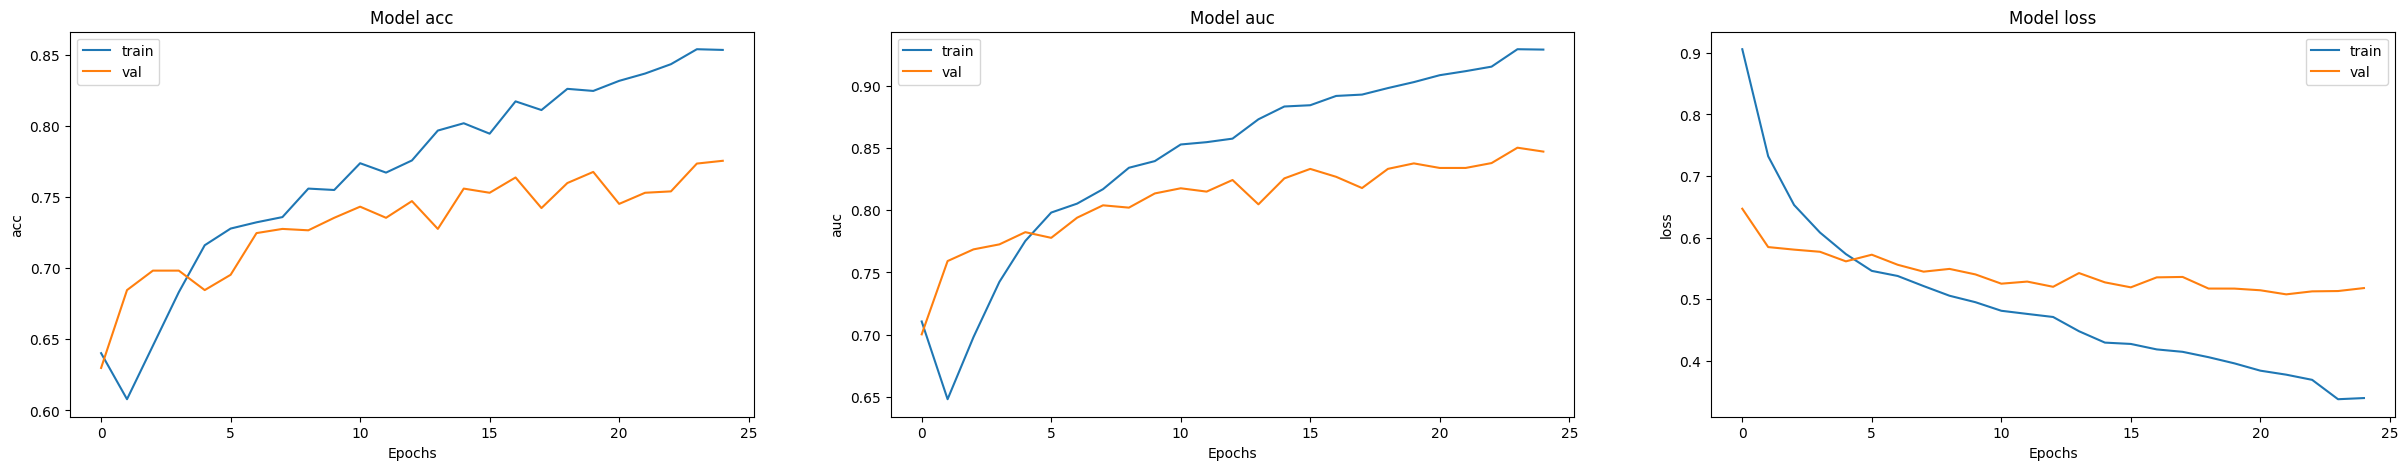

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(incept_history.history[metric])
    ax[i].plot(incept_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

40/40 [==============================] - 3s 30ms/step


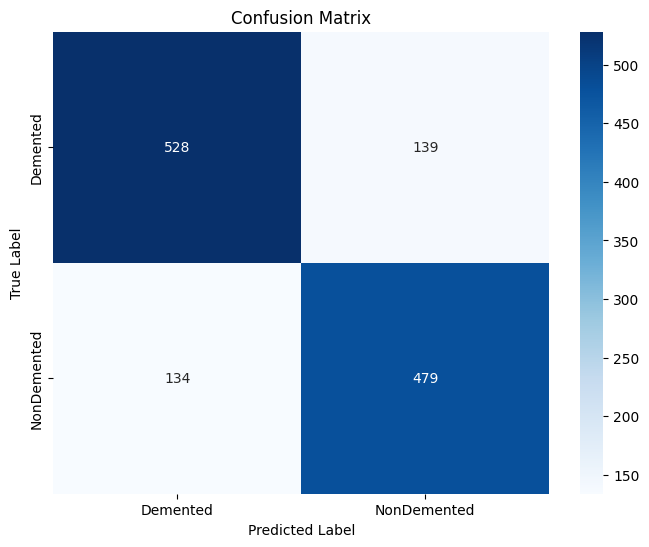

In [ ]:
# Convertendo as previsões para classes
test_predictions = inception_model.predict(test_data)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(test_true_classes, test_predictions_classes)

# Plotando a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculando métricas
accuracy = accuracy_score(test_true_classes, test_predictions_classes)
precision = precision_score(test_true_classes, test_predictions_classes, average='weighted')
recall = recall_score(test_true_classes, test_predictions_classes, average='weighted')
f1 = f1_score(test_true_classes, test_predictions_classes, average='weighted')

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Sensibilidade:", recall)
print("F1-Score:", f1)

Acurácia: 0.78671875
Precisão: 0.7868066491227427
Sensibilidade: 0.78671875
F1-Score: 0.7867506900600183


In [ ]:
# entender o que ta colaborando, quais fatias sao usadas na classificação, shap
# o que que é um unidade que ele classifica, o que é uma linha do dataset uma fatia?
# verificar dados

In [ ]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import numpy as np
import shap
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# set batch size
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
# set transformation for training and validation
transform_train = transforms.Compose([
                transforms.Resize(size = (224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5946, 0.5732, 0.5126), std=(0.2671, 0.2737, 0.3058)) # use calculated mean and std
                ])

# # define data loader
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=TRAIN_BATCH_SIZE,
#                                            shuffle=True,
#                                            num_workers=4)
# test_loader = torch.utils.data.DataLoader(test_data,
#                                           batch_size=VAL_BATCH_SIZE,
#                                           shuffle=False,
#                                           num_workers=4)

# set transformation for SHAP visualization
base_transform = transforms.Compose([
                 transforms.Resize(size = (224, 224)),
                 transforms.ToTensor()
                 ])
# set dataset
base_dataset = datasets.ImageFolder("./dataset", transform=base_transform)
# define data loader
base_loader = torch.utils.data.DataLoader(base_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=4)

In [ ]:
batch = next(iter(base_loader))
images, labels = batch

background = images[:61].to(device)
test_images = images[61:64].to(device)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [ ]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

AttributeError: ignored